# Fake news prediction model

## Dependencies

In [2]:
import pandas as pd
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

## Data processing

### Loading the cleaned data

In [3]:
from tqdm import tqdm
# Set a chunk size (e.g., 1000 rows per chunk, adjust based on file size)
chunk_size = 1000
rows = 903678
chunks = []

# Use tqdm to show progress while iterating over chunks
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(chunk_size)

# Combine all chunks into a single DataFrame
df = pd.concat(chunks)

train_data = pd.read_csv("data_cleaned_fr.csv")

Loading csv file: 904000it [00:24, 36835.04it/s]                            


### Distribution

In [6]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']==0])}')
print(f'Reliable article amount: {len(df[df['type']==1])}')
print(f'Reliable percentage: {(len(df[df['type']==1])/len(df['type'])*100):.2f}%')

Total article amount: 903678
Fake article amount: 329953
Reliable article amount: 573725
Reliable percentage: 63.49%


### Splitting

In [4]:
X = train_data['content']
y = train_data['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Vectorization

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
1    458980
0    263962
Name: count, dtype: int64
Test class distribution:
type
1    114745
0     65991
Name: count, dtype: int64


### Over sampling

In [6]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
1    458980
0    458980
Name: count, dtype: int64


## Training and evaluation

### Model training

In [7]:
classifier = MultinomialNB()
classifier.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

### Evaluation

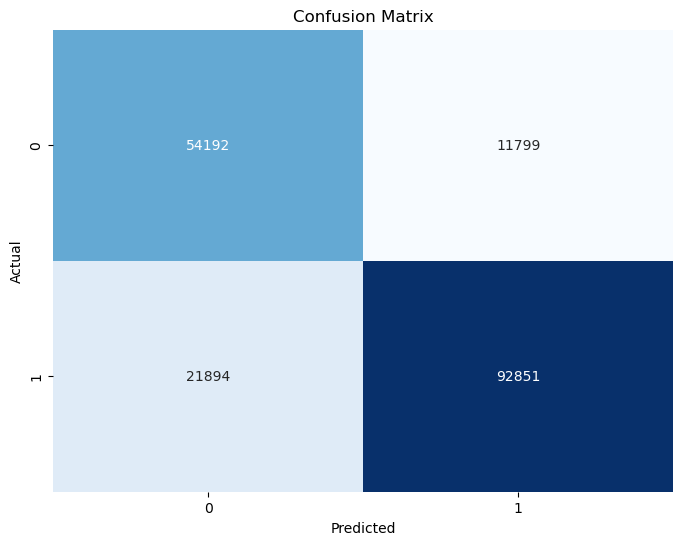

              precision    recall  f1-score   support

           0       0.71      0.82      0.76     65991
           1       0.89      0.81      0.85    114745

    accuracy                           0.81    180736
   macro avg       0.80      0.82      0.80    180736
weighted avg       0.82      0.81      0.82    180736



In [8]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))